# Lockman SWIRE master catalogue
## Preparation of Red Cluster Sequence Lensing Survey (RCSLenS) data

This catalogue comes from `dmu0_RCSLenS`.

In the catalogue, we keep:

- The `id` as unique object identifier;
- The position;
- The g, r, i, z, (no y on Lockman-SWIRE) auto magnitudes.

### Strange magnitudes

The missing values seems to be encoded as -99. but there are also quite some 99. magnitudes.

The “sensible” range of magnitudes seems to go from 14 to 37 (depending on the bands and given that 37 is really
faint and may not be reliable). In addition to that there are some very low magnitudes under -40. and very high ones
above 90. We don't know the meaning of these extreme values so we are removing all the negative magnitudes and and
those above 80.

We are also removing the sources for which we have no magnitude information given the modifications above.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
23028c5 (Thu Nov 30 18:12:00 2017 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "rcs_ra"
DEC_COL = "rcs_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        "id": "rcs_id",
        "ALPHA_J2000": "rcs_ra",
        "DELTA_J2000": "rcs_dec",
        "CLASS_STAR": "rcs_stellarity",
        "MAG_g": "m_rcs_g",
        "MAGERR_g": "merr_rcs_g",
        "MAG_r": "m_rcs_r",
        "MAGERR_r": "merr_rcs_r",        
        "MAG_i": "m_rcs_i",
        "MAGERR_i": "merr_rcs_i",
        "MAG_z": "m_rcs_z",
        "MAGERR_z": "merr_rcs_z",
        #"MAG_y": "m_rcs_y",
        #"MAGERR_y": "merr_rcs_y"    
    })


catalogue = Table.read("../../dmu0/dmu0_RCSLenS/data/RCSLenS_Lockman-SWIRE.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2017

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        # Remove missing values (-99, 99?) and extreme magnitudes (see above).
        mask = (catalogue[col] < 0) | (catalogue[col] > 80)
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))

        # We add NAN filled aperture columns because no aperture fluxes are present
        # EDIT: Better not add empty columns if we can avoid.
        #nancol = np.zeros(len(catalogue))
        #nancol.fill(np.nan)
        #catalogue.add_column(Column(nancol, 
         #                           name="m_ap{}".format(col[1:])))
        #catalogue.add_column(Column(nancol, 
        #                            name="merr_ap{}".format(col[1:])))
        #catalogue.add_column(Column(nancol, 
        #                           name="f_ap{}".format(col[1:])))
        #catalogue.add_column(Column(nancol, 
        #                           name="ferr_ap{}".format(col[1:])))
        
        # Band-flag column
        if 'ap' not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [6]:
catalogue[:10].show_in_notebook()

idx,rcs_id,rcs_ra,rcs_dec,rcs_stellarity,m_rcs_g,merr_rcs_g,m_rcs_r,merr_rcs_r,m_rcs_i,merr_rcs_i,m_rcs_z,merr_rcs_z,f_rcs_g,ferr_rcs_g,flag_rcs_g,f_rcs_r,ferr_rcs_r,flag_rcs_r,f_rcs_i,ferr_rcs_i,flag_rcs_i,f_rcs_z,ferr_rcs_z,flag_rcs_z
0,CDE1040B3_008051,162.7980696,57.8462577,0.35,25.1618,0.0697623,23.9381,0.0334968,22.6801,0.0217731,22.3473,0.0413988,0.312809,0.0200991,False,0.965516,0.0297878,False,3.07581,0.0616816,False,4.17907,0.159347,False
1,CDE1040B3_008092,162.8203016,57.8467287,0.69,24.8891,0.0495108,24.548,0.0452512,24.0667,0.0545663,23.9566,0.132427,0.402124,0.0183373,False,0.550554,0.0229459,False,0.85767,0.0431043,False,0.949205,0.115774,False
2,CDE1040B3_008109,162.8056847,57.8469354,0.02,24.0753,0.0394333,24.0281,0.0442413,23.7282,0.0626359,nan,nan,0.850902,0.0309043,False,0.88871,0.0362129,False,1.17144,0.06758,False,nan,nan,False
3,CDE1040B3_008126,162.7844289,57.8470931,0.61,24.8095,0.0615288,24.7486,0.0694756,24.689,0.123541,nan,nan,0.432713,0.0245219,False,0.457678,0.0292865,False,0.483504,0.0550157,False,nan,nan,False
4,CDE1040B3_008157,162.8025215,57.8472832,0.98,nan,nan,22.3103,0.00966064,21.9649,0.0112024,21.7301,0.0225916,nan,nan,False,4.32394,0.0384734,False,5.94347,0.0613235,False,7.37835,0.153526,False
5,CDE1040B3_008160,162.7540796,57.8472555,0.37,25.4333,0.0990134,24.7743,0.0724826,nan,nan,nan,nan,0.243601,0.0222152,False,0.446972,0.0298394,False,nan,nan,False,nan,nan,False
6,CDE1040B3_008169,162.7612297,57.8473226,0.14,24.471,0.0586908,23.695,0.0393606,23.7305,0.0741098,23.0113,0.107709,0.591017,0.0319481,False,1.20781,0.0437862,False,1.16896,0.0797905,False,2.26715,0.22491,False
7,CDE1040B3_008193,162.6800562,57.8472861,0.58,24.388,0.0804324,24.1185,0.0786203,24.3138,0.175572,nan,nan,0.637969,0.0472614,False,0.817711,0.0592121,False,0.683092,0.110461,False,nan,nan,False
8,CDE1040B3_008200,162.7555299,57.8475131,0.53,24.8821,0.0969365,24.338,0.0775129,nan,nan,23.0418,0.129057,0.404725,0.0361346,False,0.668036,0.0476925,False,nan,nan,False,2.20435,0.262022,False
9,CDE1040B3_008206,162.6779324,57.8474348,0.59,24.157,0.0394904,24.015,0.0415514,23.6005,0.0534222,23.122,0.0946982,0.789224,0.0287056,False,0.899498,0.034424,False,1.31765,0.0648331,False,2.04739,0.178574,False


### 1.1 Remove all nan rows

In [7]:
orig_len = len(catalogue)
mask = ~(np.isnan(catalogue['m_rcs_g']) 
        & np.isnan(catalogue['m_rcs_r'])
        & np.isnan(catalogue['m_rcs_i'])
        & np.isnan(catalogue['m_rcs_z'])
        #& np.isnan(catalogue['m_rcs_y'])
        )
catalogue = catalogue[mask]
print(orig_len-len(catalogue), 'out of ', orig_len, ' objects removed due to all nan magnitudes.')

41802 out of  221225  objects removed due to all nan magnitudes.


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = []
FLAG_NAME = 'rcs_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(
    catalogue, RA_COL, DEC_COL, 
    sort_col= SORT_COLS,
    flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 179423 sources.
The cleaned catalogue has 175657 sources (3766 removed).
The cleaned catalogue has 3767 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Lockman-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

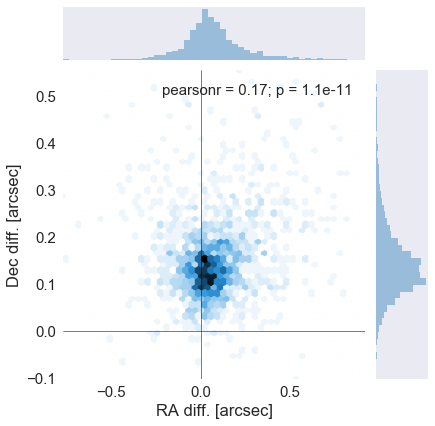

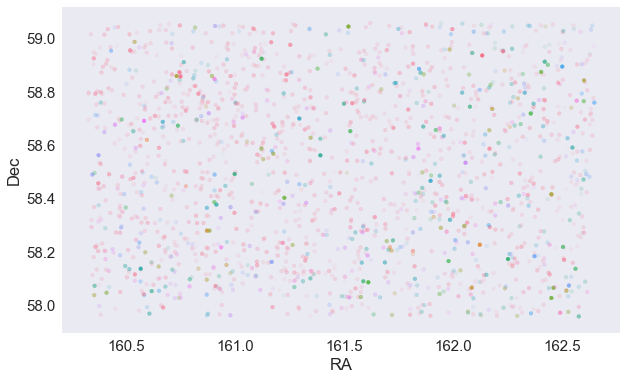

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.05095286455798487 arcsec
Dec correction: -0.1331458505944738 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

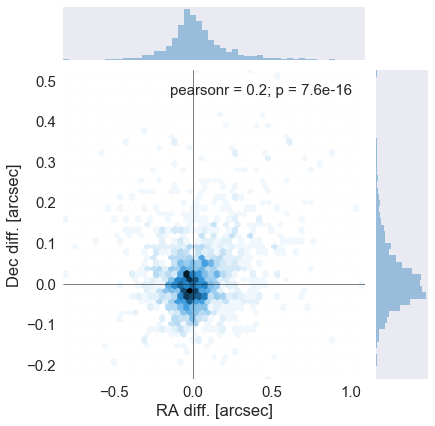

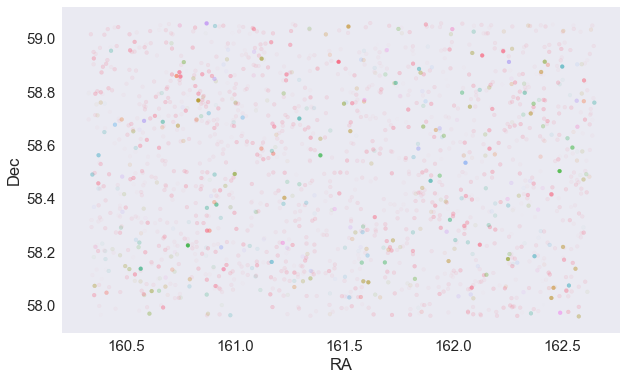

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "rcs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

1622 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/RCSLenS.fits".format(OUT_DIR), overwrite=True)